# Transformers

Nous utilisons l'architecture Transformer qui est décrite dans [ce papier](https://arxiv.org/abs/1810.04805) pour la traduction et qui est illustrée ci-dessous.

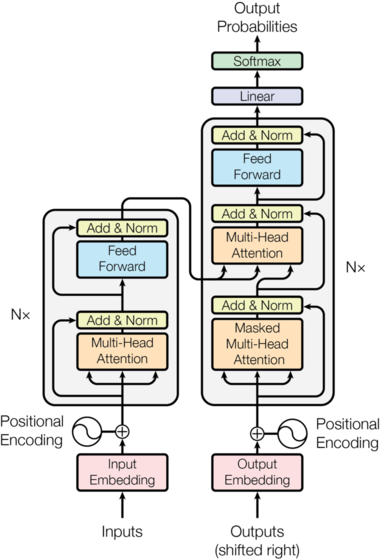





Dans notre cas, nous ferons certaines modifications afin que le modèle transformers soit adapté à la classification. 


 - Seul l'encoder sera utilisé
 - Pas de masques
 - L'attention multi-têtes (Multihead attention) et le FFN (positionwise feedforward network) permettront d'extraire les features
 - Enfin, une couche linéaire pour obtenir le label 


## Préparation des données


In [1]:
import os
import sys
import torch
from torch.nn import functional as F
import numpy as np
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe
import pandas as pd
import torch
from torchtext import data
import spacy
import random

# pour la reproductibilité
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
NLP = spacy.load('en')
tokenizer = lambda sent: [x.text for x in NLP.tokenizer(sent) if x.text != " "]

MAX_SEN_LEN = 512
TEXT = data.Field(sequential=True, tokenize=tokenizer, include_lengths = True,lower=True, fix_length= MAX_SEN_LEN)
LABEL = data.LabelField(dtype = torch.float)

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
test_data, valid_data = test_data.split(random_state = random.seed(1234))

print(f'Taille des données train: {len(train_data)}')
print(f'Taille des données de validation: {len(valid_data)}')
print(f'Taille des données test: {len(test_data)}')

Taille des données train: 25000
Taille des données de validation: 7500
Taille des données test: 17500


In [2]:
MAX_VOCAB_SIZE = 50_000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE,vectors=GloVe(name='6B', dim=100))
LABEL.build_vocab(train_data )

print(f"Nombre de tokens unique dans le TEXT: {len(TEXT.vocab)}") 
print(f"Nombre unique de LABEL: {len(LABEL.vocab)}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

BATCH_SIZE = 16
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, device = device, sort_key=lambda x: len(x.text), repeat=False, shuffle=True)

Nombre de tokens unique dans le TEXT: 50002
Nombre unique de LABEL: 2


## Construire le modèle

On crée une fonction clone qui permet de produire N couches identiques.



In [3]:
import torch
from torch import nn
from torch.autograd import Variable
import copy
import math

def clones(module, N):
    "Produit N couches identiques"
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

Les embeddings : chaque mot est représenté par un vecteur (colonne ou ligne de réels), ici de dimension 512, qu'on notera dmodel comme dans le papier "Attention is all you need".


On ajoute ensuite le "positional encoding", qui est une façon d'encoder la place de chaque élément dans la séquence. Comme la longueur des phrases n'est pas prédéterminée, on va utiliser des fonctions sinusoïdales donnant de petites valeurs entre 0 et 1, pour modifier légèrement les embeddings de chaque mot. La dimension de l'embedding de position (à sommer avec l'embedding sémantique du mot) est la même que celle de l'embedding sémantique, soit $d_{model}$, pour pouvoir sommer terme à terme.

$$PE(pos,2i)=sin\Big(\frac{pos}{10000^{2i/d_{model}}}\Big)$$
$$PE(pos,2i+1)=cos\Big(\frac{pos}{10000^{2i/d_{model}}}\Big)$$


où pos est la position et i la dimension. 




In [4]:
class Embeddings(nn.Module):

    def __init__(self, vocab, d_model): #,weights):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        #self.lut.weights = nn.Parameter(weights, requires_grad=False)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) #* math.sqrt(self.d_model)
   
class PositionalEncoder(nn.Module):
    def __init__(self, d_model,dropout, max_seq_len = MAX_SEN_LEN):
        super().__init__()
        self.d_model = d_model
        
        # create constant 'pe' matrix with values dependant on 
        # pos and i
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = \
                math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = \
                math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
                
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
 
    
    def forward(self, x):
        # rendre les embeddings plus grands
        x = x * math.sqrt(self.d_model)

        seq_len = x.size(1)
        x = x + Variable(self.pe[:,:seq_len], \
        requires_grad=False)
        return x

Ensuite nous implémentons les couches LayerNorm et Sublayer.

L'output de chaque sous-couche est **LayerNorm(x+Sublayer(x))**.

On applique un dropout pour l'output de chaque Sublayer avant qu'il soit normalisé.

Toutes les couches du modèle ainsi que les embedding produisent des outputs de dimension **d_model**
.

In [5]:
class Norm(nn.Module):
    "Normalisation"
    def __init__(self, features, eps=1e-5):
        super(Norm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
    
class SublayerOutput(nn.Module):
    '''
    Une connection résiduelle suivie par une couche Norm
    '''
    def __init__(self, size, dropout):
        super(SublayerOutput, self).__init__()
        self.norm = Norm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):

        return x + self.dropout(sublayer(self.norm(x)))

## Position-wise Feed-Forward Networks


En plus des sous-couches d'attention, chaque couche dans l'encoder contient un fully connected feed-forward network qui est appliqué à chaque position.

Cela consiste en deux transformations linéaires avec une couche d'activation ReLU entre elles. 
$$FFN(x)=max(0,xW_1+b_1)W_2+b_2$$



In [6]:
class FeedForward(nn.Module):
    "Positionwise feed-forward network."
    def __init__(self, d_model, d_ff, dropout=0.4):
        super(FeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        "Implémentation de l'équation FFN ."
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## Encoder

 - Encoder est composé de N couches identiques
 - Chaque couche a 2 sous-couches : (1) Multi-head attention (2) 2-couches feed-forward network
 - Chaque sous-couche a : (1) Residual (2) Layer normalization 
 - L'output de chaque sous-couche est  Norm(x+Sublayer(x))
 - Dans une couche d'attention, les keys, values et queries proviennent de l'output de la couche précédente dans l'encoder

In [7]:
class EncoderLayer(nn.Module):
    '''
    Couche encoder
    '''
    def __init__(self, d_model, heads, d_ff,dropout = 0.4):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model,d_ff)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x
    
class Encoder(nn.Module):
    '''
    Transformer Encoder
    
    C'est un ensemble de N couches.
    '''
    def __init__(self, vocab_size, d_model, N, d_ff, heads):
        super().__init__()
        self.N = N
        self.embed = Embeddings(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model,0.4)
        self.layers = clones(EncoderLayer(d_model, heads, d_ff), N)
        self.norm = Norm(d_model)
    def forward(self, src):
        x = self.embed(src)
        x = self.pe(x)
        for i in range(N):
            x = self.layers[i](x, mask = None)
        return self.norm(x)

## Attention

Chaque mot, décrit comme la somme de ses embeddings sémantiques et positionnels va être décomposé en trois abstractions, :

. Q : Une requête (query)

. K : Une clé (key)

. V : Une valeur (value)

On calcule l'attention à l'aide de la formule suivante : 

$$Attention(Q,K,V) = softmax\Big(\frac{QK^T}{\sqrt{d_k}}\Big)V$$

Enfin on concatène la sortie de chaque tête, et on multiplie par une matrice W0, de dimensions $d_{model}$ x $d_{model}$ ([(nombre de têtes) x (dimension requête ou clé ou valeur)]x[dimension des embeddings]).

In [8]:
def attention(q, k, v, d_k, mask=None, dropout=None):
    
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    scores = F.softmax(scores, dim=-1)
    
    if dropout is not None:
        scores = dropout(scores)
        
    output = torch.matmul(scores, v)
    return output


class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.6):
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        
        bs = q.size(0)
        
        
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)

       
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        
        concat = scores.transpose(1,2).contiguous()\
        .view(bs, -1, self.d_model)
        
        output = self.out(concat)
    
        return output

On a alors le modèle final suivant : 

In [9]:
class Transformer(nn.Module):
    def __init__(self, N, d_model, d_ff, h, dropout, output_size,batch_size, vocab):
        super().__init__()
        self.encoder = Encoder(vocab, d_model, N, d_ff, h)
        self.fc = nn.Linear(
            d_model,
            output_size
        )
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, src):
        e_outputs = self.encoder(src.permute(1,0))
        final_feature_map = e_outputs[:,-1,:]       
        final_out = self.fc(final_feature_map)
        
        return self.softmax(final_out)


In [10]:
import numpy as np
from copy import deepcopy
import torch.optim as optim
from torch.nn import functional as F

N = 6 #1 Transformer Paper
D_MODEL = 512  #256  Transformer Paper
D_FF = 2048  #512  Transformer Paper
H = 8
DROPOUT = 0.7
OUTPUT_SIZE = 2


model = Transformer(N, D_MODEL,D_FF, H, DROPOUT,OUTPUT_SIZE,BATCH_SIZE, len(TEXT.vocab))#, TEXT.vocab.vectors)
if torch.cuda.is_available():
    model.cuda()

In [11]:
def optimiseur(model, lr=1e-4, eps=1e-6, weight_decay_rate=0.001, second_weight_decay_rate=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay_rate': weight_decay_rate},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay_rate': second_weight_decay_rate}]
    return optim.Adam(
        optimizer_grouped_parameters,
        lr=lr,
        eps=eps
    )

optimizer = optimiseur(model, lr=1e-4, eps=1e-6, weight_decay_rate=0.001, second_weight_decay_rate=0.0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.05)
criterion = F.cross_entropy # on utilise la loss cross_entropy

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Le modèle a {count_parameters(model):,} paramètres à entraîner')

Le modèle a 44,517,378 paramètres à entraîner


## Entraînement

In [13]:
def binary_accuracy( preds, y):
    """
    Retourne l'accuracy par batch
    """
    #arrondi la prédiction à l'entier le plus proche
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc


In [14]:
def train_model(model, iterator):
        
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        text = batch.text[0]            
        target = batch.label 

        if (text.size()[1] is not BATCH_SIZE):
            continue
        predictions = model(text)

        target = torch.autograd.Variable(target).long()

        loss = criterion(predictions, target)
            
        pred = torch.max(predictions, 1)[1].view(target.size()).data
        acc = binary_accuracy(pred.float(), target)
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()        
 
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator):
      
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
      
    with torch.no_grad():    
        for batch in iterator:

            text = batch.text[0]
            if (text.size()[1] is not BATCH_SIZE):
                continue
            target = batch.label 
            predictions = model(text)
      
            target = torch.autograd.Variable(target).long()
            loss = criterion(predictions, target )
            pred = torch.max(predictions, 1)[1].view(target.size()).data
              
            acc = binary_accuracy(pred.float(), target)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
  
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [15]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

tloss = []
tacc = []
vloss = []
vacc = []
N_EPOCHS = 20

best_valid_loss = float('inf')
start_train = time.time()

for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss, train_acc = train_model(model, train_iterator)
    tloss.append(train_loss)
    tacc.append(train_acc) 
    scheduler.step()
    valid_loss, valid_acc = evaluate(model, valid_iterator)
    vloss.append(valid_loss)
    vacc.append(valid_acc)    

    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut7-model.pt')
    if epoch%5 == 0 :
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 6m 55s
	Train Loss: 0.595 | Train Acc: 68.55%
	 Val. Loss: 0.541 |  Val. Acc: 75.19%
Epoch: 06 | Epoch Time: 7m 41s
	Train Loss: 0.530 | Train Acc: 77.04%
	 Val. Loss: 0.526 |  Val. Acc: 76.77%
Epoch: 11 | Epoch Time: 7m 42s
	Train Loss: 0.530 | Train Acc: 77.05%
	 Val. Loss: 0.526 |  Val. Acc: 76.77%
Epoch: 16 | Epoch Time: 6m 23s
	Train Loss: 0.531 | Train Acc: 77.06%
	 Val. Loss: 0.526 |  Val. Acc: 76.77%


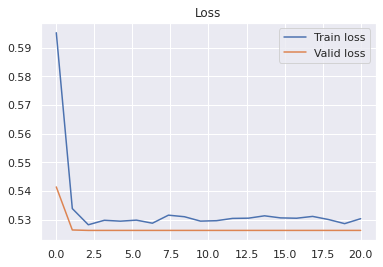

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
sns.set()

x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,tloss)
plt.plot(x,vloss)
plt.title("Loss")
plt.legend(["Train loss", "Valid loss"])


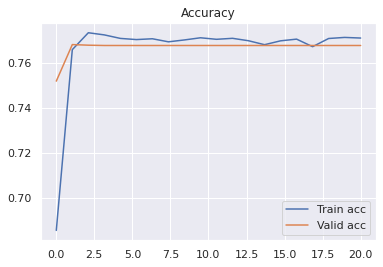

In [17]:
plt.plot(x,tacc)
plt.plot(x,vacc)
plt.title("Accuracy")
plt.legend(["Train acc", "Valid acc"])

## Tester

In [18]:
model.load_state_dict(torch.load('tut7-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.523 | Test Acc: 77.69%


In [19]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor))
    out = F.softmax(prediction, 1)

    pred = torch.max(prediction, 1)[1].view(1).data
    if ((pred.item()) == 1):
        print ("Sentiment: Positive")
    else:
        print ("Sentiment: Negative")

predict_sentiment(model, "this movie is not good at all")

Sentiment: Negative


In [20]:
predict_sentiment(model, "This film is great good ")

Sentiment: Positive


In [21]:
predict_sentiment(model, "This film is bad terrible ")

Sentiment: Negative
